In [1]:
import sys

if "../" not in sys.path:
    sys.path.append("../")

from time_series_dataset import SalesDataset

batch_size = 16

sdata = SalesDataset(
    train_path="../../../data/train.csv", 
    test_path="../../../data/test.csv", 
    oil_path="../../../data/oil.csv"
)

train_loader, val_loader = sdata.get_loaders(include_exog=True, batch_size=batch_size)
x, y = next(iter(train_loader))
input_size = x.shape[-1]

/Users/cullenpaulisick/opt/anaconda3/envs/default_ml_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [3]:
import torch
from torch.utils.tensorboard import SummaryWriter



from torch import nn
from lstm import TimeSeriesLSTM

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
# test that dimensions are as expected
train_loader_i = iter(train_loader)
# retrieve sample data to learn from 
x, y = next(train_loader_i)
test_input = torch.Tensor(x).float()
print('Input size: ', test_input.size())
test_rnn = TimeSeriesLSTM(input_size=input_size, output_size=1, hidden_dim=32, n_layers=2)
test_rnn = test_rnn.float()
# # test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h[0].size())
print('Cell state size: ', test_h[1].size())

Input size:  torch.Size([16, 20, 2])
No GPU available, training on CPU; consider making n_epochs very small.
Output size:  torch.Size([16, 20, 1])
Hidden state size:  torch.Size([2, 16, 32])
Cell state size:  torch.Size([2, 16, 32])


In [4]:
# decide on hyperparameters
hparams = dict(
input_size=2,
output_size=1,
hidden_dim=128,
n_layers=3,
drop_prob=0.8,
lr = 0.0025
)

with SummaryWriter() as w:
    # instantiate an LSTM with regularization
    lstm = TimeSeriesLSTM(hparams['input_size'], 
                hparams['output_size'], 
                hparams['hidden_dim'],
                hparams['n_layers'], 
                drop_prob=hparams['drop_prob'])
    # MSE loss and Adam optimizer with a learning rate of 0.01
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=hparams['lr']) 
    
    train_loss, val_loss = lstm.training_cycle(
        batch_size=batch_size,
        train_loader=train_loader, 
        val_loader=val_loader, 
        epochs=300, 
        print_every=30, 
        criterion=criterion, 
        optimizer=optimizer,
        writer=w
    )
    w.add_hparams(hparam_dict=hparams, 
                  metric_dict={
                        "hparam/train_loss":train_loss,
                        "hparam/val_loss":val_loss
                    }
                )
    w.close()


No GPU available, training on CPU; consider making n_epochs very small.
Epoch: 0, train loss: 9.37773, val loss: 37.66195
Epoch: 30, train loss: 1.71578, val loss: 5.31327
Epoch: 60, train loss: 1.51080, val loss: 4.20528
Epoch: 90, train loss: 1.38461, val loss: 3.19766
Epoch: 120, train loss: 1.33325, val loss: 3.17895
Epoch: 150, train loss: 1.32618, val loss: 2.92607
Epoch: 180, train loss: 1.30910, val loss: 2.87227
Epoch: 210, train loss: 1.29854, val loss: 2.96607
Epoch: 240, train loss: 1.24698, val loss: 2.59106
Epoch: 270, train loss: 1.21968, val loss: 2.78265
Epoch: 299, train loss: 1.22867, val loss: 3.21343


In [5]:
val_loader_i = iter(val_loader)

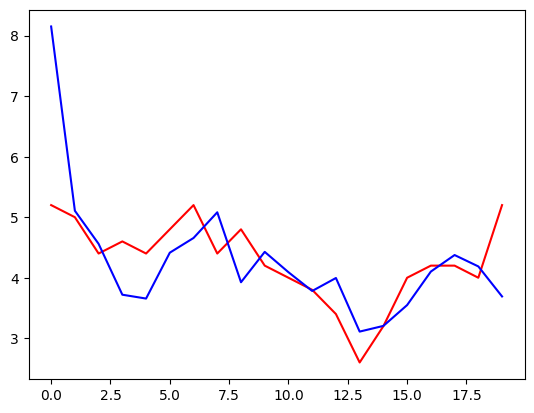

In [10]:
# sample inference

time_steps = range(20)

val_x, val_y = next(val_loader_i)

# blue for prediction, red for actual/input
lstm.display_inference(val_x, val_y)
